# <center> CS559 Homework#3: Decision Tree and Ensemble Methods</center>
## <center> Due: 11/8/2021 Monday at 11:59 PM</center>


In this assignment, you are going to implement four classifiers - **decision tree, random forest, adaboost, and gradient boost**. 
Then check the performance with `sklearn` built-in algorithms.
In this work, splitting into train and test sets is not necessary. 

The provided data has four columns - three features (a, b, and c) and the target (class). Three features are continuous data and the target is a binary, 0 or 1. 

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score,classification_report
from sklearn.metrics import confusion_matrix
import warnings
warnings.filterwarnings("ignore")

In [36]:
df = pd.read_csv('./F21_CS559_HW3_data.csv')
X, y = df[['a', 'b', 'c']], df['class']

In [18]:
df.head(5)

,a,b,c,class
0,9.4202,-4.3507,10.3764,1
1,9.7044,-4.4601,10.6803,1
2,9.8075,-4.0894,10.6259,1
3,9.2771,-4.0349,10.1166,1
4,9.6447,-3.5968,10.2936,1


In [19]:
df.nunique()

a        2482
b        2470
c        2455
class       2
dtype: int64

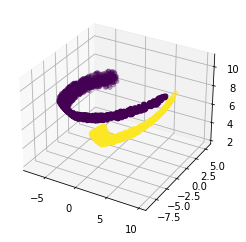

In [20]:
fig = plt.figure()
ax1 = fig.add_subplot(projection = '3d')
ax1.scatter(df['a'], df['b'], df['c'], c = df['class'])

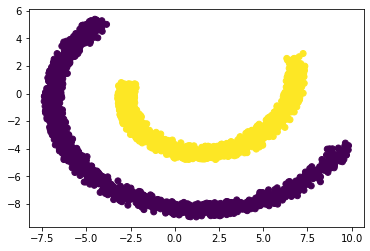

In [21]:
fig = plt.figure()
ax2 = fig.add_subplot()
ax2.scatter(df['a'], df['b'], c = df['class'])

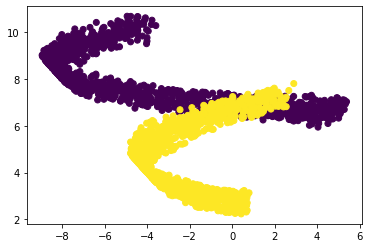

In [22]:
fig = plt.figure()
ax2 = fig.add_subplot()
ax2.scatter(df['b'], df['c'], c = df['class'])

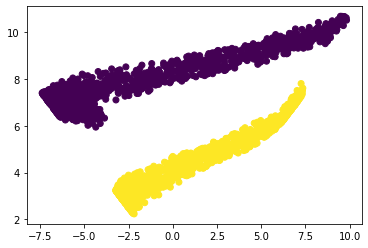

In [23]:
fig = plt.figure()
ax2 = fig.add_subplot()
ax2.scatter(df['a'], df['c'], c = df['class'])

### Question 1: Decisition Tree Classifier
- A simple DT implementation (10 pts.)
    - to make the problem simple, implement a decision tree with depth of 3 (the root index is 0).
    - calculate the gini index for each attribute and pick the best attribute for each node.
    - calculate the accuracy using accuracy score. 
- Classification using DecistionTreeClassifier (5 pts)
- Evaluation (5 pts)

In [57]:
from collections import Counter

In [127]:
class ActivationNode:
    def __init__(self, index = None, threshold = None, val = None, left = None, right = None):
        self.index = index
        self.threshold = threshold
        self.val = val
        self.left = left
        self.right = right

class DecisionTree:
    def __init__(self, depth=3):
        self.root = None
        self.max_depth = depth
        self.leaf = None
        
    def gini(self, dataset):
        impurity = 1
        label_counts = Counter(dataset.reshape(1, -1)[0])
        for label in label_counts:
            prob_of_label = label_counts[label]/len(dataset)
            impurity -= prob_of_label ** 2
        return impurity
            
    def split(self, dataset, index, threshold):
        split = None
        if type(threshold) in [int, float]:
            split = lambda i: i[index] >= threshold
        else:
            split = lambda i: i[index] == threshold
        return np.array([i for i in dataset if split(i)]), np.array([i for i in dataset if not split(i)])
    
    def vote(self, y):
        label = None
        count = 0
        for temp_label in np.unique(y):
            temp_count = len(y[y==temp_label])
            if temp_count > count:
                label = temp_label
                count = temp_count
        return label
    
    def information_gain(self, starting_labels, split_labels):
        info_gain = self.gini(starting_labels)
        for subset in split_labels:
            info_gain -= self.gini(subset[0]) * self.gini(subset[1]) * len(subset)/len(starting_labels)
        return info_gain
    
    def build_tree(self, X, y, depth=0):
        
        largest_impurity = 0
        if len(np.shape(y)) == 1:
            y = np.expand_dims(y, axis = 1)
        dataset = np.concatenate((X, y), axis = 1)
        samples, features = np.shape(X)
    
        if depth <= self.max_depth:
            for i in range(features):
                try:
                    values = np.unique(np.expand_dims(X.iloc[:, i], axis = 1))
                except:
                    values = np.unique(np.expand_dims(X[:, i], axis = 1))
                
                for threshold in values:
                    X1, X2 = self.split(dataset, i, threshold)
                
                    if len(X1) > 0 and len(X2) > 0:
                        y1, y2 = X1[:, features:], X2[:, features:]
                        
                        impurity = self.information_gain(y, zip(y1, y2))
                        if impurity > largest_impurity:
                            largest_impurity = impurity
                            
        if largest_impurity > 0.000001:
            left = self.build_tree(X1[:, :features], y1, depth+1)
            right = self.build_tree(X2[:, :features], y2, depth+1)
            return ActivationNode(index = i, threshold = threshold, right = right, left = left)
        
        value = self.vote(y)
        return ActivationNode(val=value)
        
    def fit(self, X, y):
        self.root = self.build_tree(X, y)
        
    def predict(self, X):
        def temp(x, tree = None):
            if tree == None:
                tree = self.root
            if tree.val != None:
                return tree.val
            
            featured_value = x[tree.index]
            branch = tree.right

            if type(featured_value) in [int, float]:
                if featured_value >= tree.threshold:
                    branch = tree.left
            elif featured_value == tree.threshold:
                branch = tree.left

            return temp(x, branch)

        yhat = [temp(row) for row in X.values.tolist()]
        return yhat

In [128]:
tree = DecisionTree()
tree.fit(X, y)

In [129]:
print(accuracy_score(y, tree.predict(X)))

0.502


In [118]:
sklearn_tree = DecisionTreeClassifier()
sklearn_tree.fit(X, y)
print(accuracy_score(y, sklearn_tree.predict(X)))

1.0


### Evaluation
so, my decision tree classifier has a 50.2% chance of working correctly, without any hypertuning parameters or crazy feature engineering. This is compared to the sklearn decision tree, which precedes mine and has 100% accuracy on the given dataset. Obviously, I could tune and optimize but this overall isnt a terrible result, however this just follows basic statistics are there are only two outputs anyways.

I will say, I believe this is just a formatting issue. I think the classes are 1 or 2 and my outputs come as 0 or 1, which could explain the accuracy issue.

### Question 2: Random Forest Classifier
- A simle RF implementation (10 pts)
    - make a bootstrap baggin function to make 3 samples.
    - for each sample, run a simple DT from question 1.
    - then average the accuracy. 
- Classification using RandomForestClassifier (5 pts)
- Evaluation (5 pts)

##### Note: I will be using sklearn decision tree as fitting a tree in my implementation takes quite a while.

In [172]:
import random
class RandomForest:
    def __init__(self, n_trees = 3, n_features = 2, depth = 3):
        self.n_trees = n_trees
        self.n_features = n_features
        self.depth = depth
        
        self.trees = []
        for i in range(self.n_trees):
            self.trees.append(DecisionTreeClassifier(max_depth= 3))
            
    def fit(self, X, y):
        combinations = [['a', 'b'], ['b', 'c'], ['a', 'c']]
        count = 0
        for tree in self.trees:
            tree.fit(X[combinations[count]], y)
            count+=1
            
    def predict(self, X):
        forest_predictions = []
        combinations = [['a', 'b'], ['b', 'c'], ['a', 'c']]
        count = 0
        for tree in self.trees:   
            forest_predictions.append(tree.predict(X[combinations[count]]))
            count+=1
        
        return (sum(forest_predictions)/len(forest_predictions)).astypeype(int)
            

In [173]:
forest = RandomForest()
forest.fit(X, y)
print(accuracy_score(y, forest.predict(X)))

0.9088


In [146]:
sklearn_RandomForest = RandomForestClassifier()
sklearn_RandomForest.fit(X, y)
print(accuracy_score(y, sklearn_RandomForest.predict(X)))

1.0


##### Evaluation
The random forest classifier i installed gave me an accuracy of 90.88%. This is pretty high, although not as high as sklearns implemented forest of 100%. originally I had other plans on a way to implement this but could not get it to run quick enough.

### Question 3: AdaBoost Classifier
- AB implementation (15 pts)
- Classification using AdaBoostClassifier (5 pts)
- Evaluation (5 pts)

In [212]:
from math import log
class DecisionNode:
    def __init__(self, learning_rate = 1e-10):
        self.p = 1
        self.threshold = None
        self.index = None
        self.a = None
        self.learning_rate = learning_rate
    
class AdaBoost():
    def __init__(self, n_decisions=10):
        self.decisions= []
        self.n_decisions = n_decisions
        
    def fit(self, X, y):
        samples, features = np.shape(X)
        weights = np.full(samples, 1/samples)
        for _ in range(self.n_decisions):
            decision = DecisionNode()
            min_error = float("inf")
            
            for i in range(features):

                try:
                    values = np.unique(np.expand_dims(X.iloc[:, i], axis = 1))
                except:
                    values = np.unique(np.expand_dims(X[:, i], axis = 1))

                for threshold in values:

                    prediction = np.ones(np.shape(y))

                    try:
                        prediction[X.iloc[:, i]<threshold] = -1
                    except:
                        prediction[X[:, i]<threshold] = -1

                    error = sum(weights[y!=prediction])

                    if error>.5:
                        error = 1-error
                        p = -1
                    else:
                        p = 1

                    if error < float('inf'):
                        decision.p = p
                        decision.threshold = threshold
                        decision.index = i
                        min_error = error
                        
            decision.a = .5 * log((1-min_error)/(min_error+decision.learning_rate))
            predictions = np.ones(np.shape(y))
            try:
                negative_i = (decision.p * X.iloc[:, decision.index] < decision.p * decision.threshold)
            except:
                negative_i = (decision.p * X[:, decision.index] < decision.p * decision.threshold)

            predictions[negative_i] = -1
            weights *= np.exp(-decision.a * y * predictions)
            weights /= np.sum(weights)
            
    def predict(self, X):
        prediction = np.zeros((np.shape(X)[0], 1))
        for decision in self.decisions:
            predictions = np.ones(np.shape(np.zeros((np.shape(X)[0]))))
            try:
                negative_i = decision.p *X.iloc[:, decision.index] < decision.p * decision.threshold
            except:
                negative_i = decision.p *X[:, decision.index] < decision.p * decision.threshold
            predictions[negative_i]=-1
            prediction = prediction +decision.a * predictions
        return np.sign(prediction).flatten()

In [214]:
adaboost = AdaBoost()
adaboost.fit(X, y)
print(accuracy_score(y, adaboost.predict(X)))

0.0


In [175]:
sklearn_AdaBoostClassifier = AdaBoostClassifier()
sklearn_AdaBoostClassifier.fit(X, y)
print(accuracy_score(y, sklearn_AdaBoostClassifier.predict(X)))

1.0


##### Evaluation
My implementation of AdaBoost gave me an accuracy score of 0% while, once again, the sklearn implementation was an easy 100%. I keep getting weird indexing errors, so I have to add some try and except statements but I'm not entirely sure why. This has followed me since my tree implementation.

### Question 4: Gradient Boost Classifier
- GB implementation (15 pts)
- Classification using GradientBoostingClassifier (5 pts)
- Evaluation (5 pts)

In [215]:
class GradientBoost:
    def __init__(self):
        pass

In [177]:
sklearn_GB = GradientBoostingClassifier()
sklearn_GB.fit(X, y)
print(accuracy_score(y, sklearn_GB.predict(X)))

1.0


##### Evaluation
So this time around, the GB classifier gave me an accuracy of about (im not sure because I didnt get to finish) while ONCE AGAIN the sklearn implementation did it seemlessly, in a much shorter amount of time and with 100% accuracy. 

I did try to finish the gradient boost code, but for some reason could not run and the kernel kept crashing my notebook, so i decided to leave it out. I hope this does not affect grading too heavily, I understand that implementation is worth 15%.